<a href="https://colab.research.google.com/github/o7s8r6/CVIVAAN/blob/main/nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

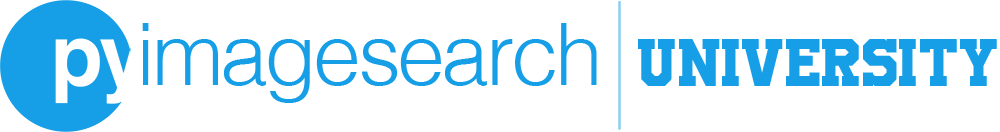

# Computer Graphics and Deep Learning with NeRF using TensorFlow and Keras
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the Computer Graphics and Deep Learning with NeRF using TensorFlow and Keras Series.
- [Part 1](https://www.pyimagesearch.com/2021/11/10/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-1/) published on 2021-11-10.
- [Part 2](https://www.pyimagesearch.com/2021/11/17/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-2/) published on 2021-11-17
- [Part 3](https://www.pyimagesearch.com/2021/11/24/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-3/) published on 2021-11-24

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/neural-radiance-fields/neural-radiance-fields.zip
!unzip -qq neural-radiance-fields.zip
%cd neural-radiance-fields

### Download the dataset

⚠️ Before running any of the code below please download the dataset from [this Gdrive link](https://drive.google.com/drive/folders/128yBriW1IG_3NJ5Rp7APSTZsJqdJdfc1). The dataset is open sourced by the authors and the link can be found in the [official NeRF repository](https://github.com/bmild/nerf).

Steps to download the dataset:

- Visit this [GDrive link](https://drive.google.com/drive/folders/128yBriW1IG_3NJ5Rp7APSTZsJqdJdfc1)
- Now go into the `nerf_synthetic` folder.
- Right click on any one of the folder (eg. `lego`) and click on **download**.
- Clicking on the **downlaod** button will get you a zip file containing the entire dataset that you chose (eg. `lego.zip`)
- After downloading a dataset (eg. `lego.zip`) use the following commands to expand the zip.
```
$ unzip -qq <DATASET_NAME>.zip
$ mv <DATASET_NAME> dataset
```
In place of `<DATASET_NAME>` use the name of the dataset that you have downloaded.

After completing the dataset download, proceed to the later sections.

## Blog Post Code

### Import Packages

In [ ]:
# import the necessary packages
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.image import convert_image_dtype
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Mean
from tensorflow.image import decode_jpeg
from tensorflow.data import AUTOTUNE
from tensorflow.image import resize
from tensorflow.io import read_file
from tensorflow.keras import Input
from tensorflow.keras import Model
from IPython.display import HTML
from base64 import b64encode
from tensorflow import reshape
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import imageio
import json
import os

### Creating our configuration file

In [ ]:
class Config:
    # define the dataset path
    DATASET_PATH = "dataset"

    # define the json paths
    TRAIN_JSON = os.path.join(DATASET_PATH, "transforms_train.json")
    VAL_JSON = os.path.join(DATASET_PATH, "transforms_val.json")
    TEST_JSON = os.path.join(DATASET_PATH, "transforms_test.json")

    # define TensorFlow AUTOTUNE
    AUTO = AUTOTUNE

    # define image dimensions
    IMAGE_WIDTH = 50
    IMAGE_HEIGHT = 50

    # define the number of samples for coarse and fine model
    N_C = 16
    N_F = 32

    # define the dimension for positional encoding
    L_XYZ = 8
    L_DIR = 4

    # define the near and far bounding values of the 3D scene
    NEAR = 2.0
    FAR = 6.0

    # define the batch size
    BATCH_SIZE = 1

    # define the number of dense units
    DENSE_UNITS = 64

    # define the skip layer
    SKIP_LAYER = 4

    # define the model fit parameters
    STEPS_PER_EPOCH = 50
    VALIDATION_STEPS = 5
    EPOCHS = 20

    # define a output image path
    OUTPUT_PATH = "output"
    IMAGE_PATH = os.path.join(OUTPUT_PATH, "images")
    VIDEO_PATH = os.path.join(OUTPUT_PATH, "videos")

    # define the parameters of the rendered video
    SAMPLE_THETA_POINTS = 90
    FPS = 30
    QUALITY = 7
    MACRO_BLOCK_SIZE = None

    # define the inference video path
    OUTPUT_VIDEO_PATH = os.path.join(VIDEO_PATH, "ouptut.mp4")

    # define coarse and fine model paths
    COARSE_PATH = os.path.join(OUTPUT_PATH, "coarse")
    FINE_PATH = os.path.join(OUTPUT_PATH, "fine")

config = Config()

### Utiliy functions

In [ ]:
def get_focal_from_fov(fieldOfView, width):
	# calculate the focal length of the camera from the field of view
	focalLength = 0.5 * width / tf.tan(0.5 * fieldOfView)
	
	# return the focal length
	return focalLength

In [ ]:
def render_image_depth(rgb, sigma, tVals):
	# squeeze the last dimension of sigma
	sigma = sigma[..., 0]

	# calculate the delta between adjacent tVals
	delta = tVals[..., 1:] - tVals[..., :-1]
	deltaShape = [config.BATCH_SIZE, config.IMAGE_HEIGHT, config.IMAGE_WIDTH, 1]
	delta = tf.concat(
		[delta, tf.broadcast_to([1e10], shape=deltaShape)], axis=-1)

	# calculate alpha from sigma and delta values
	alpha = 1.0 - tf.exp(-sigma * delta)

	# calculate the exponential term for easir calculations
	expTerm = 1.0 - alpha
	epsilon = 1e-10

	# calculate the transmittance and weights of the ray points
	transmittance = tf.math.cumprod(expTerm + epsilon, axis=-1,
		exclusive=True)
	weights = alpha * transmittance
	
	# build the image and depth map from the points of the rays
	image = tf.reduce_sum(weights[..., None] * rgb, axis=-2)
	depth = tf.reduce_sum(weights * tVals, axis=-1)
	
	# return rgb, depth map and weights
	return (image, depth, weights)

In [ ]:
def sample_pdf(tValsMid, weights, nF):
	# add a small value to the weights to prevent it form nan
	weights += 1e-5

	# normalize the weights to get the pdf
	pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)

	# from pdf to cdf transformation
	cdf = tf.cumsum(pdf, axis=-1)

	# start the cdf with 0s
	cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

	# get the sample points
	uShape = [config.BATCH_SIZE, config.IMAGE_HEIGHT, config.IMAGE_WIDTH, nF]
	u = tf.random.uniform(shape=uShape)

	# get the indices of the points of u when u is inserted into cdf in a
	# sorted manner
	indices = tf.searchsorted(cdf, u, side="right")

	# define the boundaries
	below = tf.maximum(0, indices-1)
	above = tf.minimum(cdf.shape[-1]-1, indices)
	indicesG = tf.stack([below, above], axis=-1)
	
	# gather the cdf according to the indices
	cdfG = tf.gather(cdf, indicesG, axis=-1,
		batch_dims=len(indicesG.shape)-2)
	
	# gather the tVals according to the indices
	tValsMidG = tf.gather(tValsMid, indicesG, axis=-1,
		batch_dims=len(indicesG.shape)-2)

	# create the samples by inverting the cdf
	denom = cdfG[..., 1] - cdfG[..., 0]
	denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
	t = (u - cdfG[..., 0]) / denom
	samples = (tValsMidG[..., 0] + t * 
		(tValsMidG[..., 1] - tValsMidG[..., 0]))
	
	# return the samples
	return samples

In [ ]:
def get_translation_t(t):
	# build the translation matrix and convert it to a tensor
	matrix = [
		[1, 0, 0, 0],
		[0, 1, 0, 0],
		[0, 0, 1, t],
		[0, 0, 0, 1],
	]
	matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
	
	# return the translation matrix
	return matrix

def get_rotation_phi(phi):
	# build the roation matrix and convert it to a tensor
	matrix = [
		[1, 0, 0, 0],
		[0, tf.cos(phi), -tf.sin(phi), 0],
		[0, tf.sin(phi), tf.cos(phi), 0],
		[0, 0, 0, 1],
	]
	matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)

	# return the rotation matrix
	return matrix

def get_rotation_theta(theta):
	# build the roation matrix and convert it to a tensor
	matrix = [
		[tf.cos(theta), 0, -tf.sin(theta), 0],
		[0, 1, 0, 0],
		[tf.sin(theta), 0, tf.cos(theta), 0],
		[0, 0, 0, 1],
	]
	matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)

	# return the rotation matrix
	return matrix

def pose_spherical(theta, phi, t):
	# compute the camera2world matrix from the give theta, phi and t
	c2w = get_translation_t(t)
	c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
	c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
	c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
	
	# return the camera2world matrix
	return c2w

### Data utils

In [ ]:
def read_json(jsonPath):
	# open the json file
	with open(jsonPath, "r") as fp:
		# read the json data
		data = json.load(fp)
	
	# return the data
	return data

In [ ]:
def get_image_c2w(jsonData, datasetPath):
	# define a list to store the image paths
	imagePaths = []
	
	# define a list to store the camera2world matrices
	c2ws = []

	# iterate over each frame of the data
	for frame in jsonData["frames"]:
		# grab the image file name
		imagePath = frame["file_path"]
		imagePath = imagePath.replace(".", datasetPath)
		imagePaths.append(f"{imagePath}.png")

		# grab the camera2world matrix
		c2ws.append(frame["transform_matrix"])
	
	# return the image file names and the camera2world matrices
	return (imagePaths, c2ws)

In [ ]:
class GetImages:
	def __init__(self, imageWidth, imageHeight):
		# define the image width and height
		self.imageWidth = imageWidth
		self.imageHeight = imageHeight

	def __call__(self, imagePath):
		# read the image file
		image = read_file(imagePath)

		# decode the image string
		image = decode_jpeg(image, 3)

		# convert the image dtype from uint8 to float32
		image = convert_image_dtype(image, dtype=tf.float32)

		# resize the image to the height and width in cofig
		image = resize(image, (self.imageWidth, self.imageHeight))
		image = reshape(image, (self.imageWidth, self.imageHeight, 3))

		# return the image
		return image

In [ ]:
class GetRays:
	def __init__(self, focalLength, imageWidth, imageHeight, near, 
		far, nC):
		# define the focal length, image width, and image height
		self.focalLength = focalLength
		self.imageWidth = imageWidth
		self.imageHeight = imageHeight

		# define the near and far bounding values
		self.near = near
		self.far = far

		# define the number of samples for coarse model
		self.nC = nC

	def __call__(self, camera2world):
		# create a meshgrid of image dimensions
		(x, y) = tf.meshgrid(
			tf.range(self.imageWidth, dtype=tf.float32),
			tf.range(self.imageHeight, dtype=tf.float32),
			indexing="xy",
		)

		# define the camera coordinates
		xCamera = (x - self.imageWidth * 0.5) / self.focalLength
		yCamera = (y - self.imageHeight * 0.5) / self.focalLength

		# define the camera vector
		xCyCzC = tf.stack([xCamera, -yCamera, -tf.ones_like(x)],
			axis=-1)

		# slice the camera2world matrix to obtain the roataion and
		# translation matrix
		rotation = camera2world[:3, :3]
		translation = camera2world[:3, -1]

		# expand the camera coordinates to 
		xCyCzC = xCyCzC[..., None, :]
		
		# get the world coordinates
		xWyWzW = xCyCzC * rotation
		
		# calculate the direciton vector of the ray
		rayD = tf.reduce_sum(xWyWzW, axis=-1)
		rayD = rayD / tf.norm(rayD, axis=-1, keepdims=True)

		# calculate the origin vector of the ray
		rayO = tf.broadcast_to(translation, tf.shape(rayD))

		# get the sample points from the ray
		tVals = tf.linspace(self.near, self.far, self.nC)
		noiseShape = list(rayO.shape[:-1]) + [self.nC]
		noise = (tf.random.uniform(shape=noiseShape) * 
			(self.far - self.near) / self.nC)
		tVals = tVals + noise

		# return ray origin, direction, and the sample points
		return (rayO, rayD, tVals)

### Positional Encoder

In [ ]:
def encoder_fn(p, L):
	# build the list of positional encodings
	gamma = [p]

	# iterate over the number of dimensions in time
	for i in range(L):
		# insert sine and cosine of the product of current dimension
		# and the position vector
		gamma.append(tf.sin((2.0 ** i) * p))
		gamma.append(tf.cos((2.0 ** i) * p))
	
	# concatenate the positional encodings into a positional vector
	gamma = tf.concat(gamma, axis=-1)

	# return the positional encoding vector
	return gamma

### NeRF Multilayer Perceptron

In [ ]:
def get_model(lxyz, lDir, batchSize, denseUnits, skipLayer):
	# build input layer for rays
	rayInput = Input(shape=(None, None, None, 2 * 3 * lxyz + 3),
		batch_size=batchSize)
	
	# build input layer for direction of the rays
	dirInput = Input(shape=(None, None, None, 2 * 3 * lDir + 3),
		batch_size=batchSize)
	
	# creating an input for the MLP
	x = rayInput
	for i in range(8):
		# build a dense layer
		x = Dense(units=denseUnits, activation="relu")(x)

		# check if we have to include residual connection
		if i % skipLayer == 0 and i > 0:
			# inject the residual connection
			x = concatenate([x, rayInput], axis=-1)
	
	# get the sigma value
	sigma = Dense(units=1, activation="relu")(x)

	# create the feature vector
	feature = Dense(units=denseUnits)(x)

	# concatenate the feature vector with the direction input and put
	# it through a dense layer
	feature = concatenate([feature, dirInput], axis=-1)
	x = Dense(units=denseUnits//2, activation="relu")(feature)

	# get the rgb value
	rgb = Dense(units=3, activation="sigmoid")(x)

	# create the nerf model
	nerfModel = Model(inputs=[rayInput, dirInput],
		outputs=[rgb, sigma])
	
	# return the nerf model
	return nerfModel

### Custom NeRF Trainer model

In [ ]:
class Nerf_Trainer(tf.keras.Model):
	def __init__(self, coarseModel, fineModel, lxyz, lDir, 
		encoderFn, renderImageDepth, samplePdf, nF):
		super().__init__()
		# define the coarse model and fine model
		self.coarseModel = coarseModel
		self.fineModel = fineModel

		# define the dimensions for positional encoding for spatial
		# coordinates and direction
		self.lxyz = lxyz
		self.lDir = lDir

		# define the positional encoder
		self.encoderFn = encoderFn

		# define the volume rendering function
		self.renderImageDepth = renderImageDepth

		# define the hierarchical sampling function and the number of
		# samples for the fine model
		self.samplePdf = samplePdf
		self.nF = nF

	def compile(self, optimizerCoarse, optimizerFine, lossFn):
		super().compile()
		# define the optimizer for the coarse and fine model
		self.optimizerCoarse = optimizerCoarse
		self.optimizerFine = optimizerFine

		# define the photometric loss function
		self.lossFn = lossFn

		# define the loss and psnr tracker
		self.lossTracker = Mean(name="loss")
		self.psnrMetric = Mean(name="psnr")

	def train_step(self, inputs):
		# get the images and the rays
		(elements, images) = inputs
		(raysOriCoarse, raysDirCoarse, tValsCoarse) = elements

		# generate the coarse rays
		raysCoarse = (raysOriCoarse[..., None, :] + 
			(raysDirCoarse[..., None, :] * tValsCoarse[..., None]))

		# positional encode the rays and dirs
		raysCoarse = self.encoderFn(raysCoarse, self.lxyz)
		dirCoarseShape = tf.shape(raysCoarse[..., :3])
		dirsCoarse = tf.broadcast_to(raysDirCoarse[..., None, :],
			shape=dirCoarseShape)
		dirsCoarse = self.encoderFn(dirsCoarse, self.lDir)

		# keep track of our gradients
		with tf.GradientTape() as coarseTape:
			# compute the predictions from the coarse model
			(rgbCoarse, sigmaCoarse) = self.coarseModel([raysCoarse, 
				dirsCoarse])
			
			# render the image from the predicitons
			renderCoarse = self.renderImageDepth(rgb=rgbCoarse,
				sigma=sigmaCoarse, tVals=tValsCoarse)
			(imagesCoarse, _, weightsCoarse) = renderCoarse

			# compute the photometric loss
			lossCoarse = self.lossFn(images, imagesCoarse)

		# compute the middle values of t vals
		tValsCoarseMid = (0.5 * 
			(tValsCoarse[..., 1:] + tValsCoarse[..., :-1]))

		# apply hierarchical sampling and get the t vals for the fine
		# model
		tValsFine = self.samplePdf(tValsMid=tValsCoarseMid,
			weights=weightsCoarse, nF=self.nF)
		tValsFine = tf.sort(
			tf.concat([tValsCoarse, tValsFine], axis=-1), axis=-1)

		# build the fine rays and positional encode it
		raysFine = (raysOriCoarse[..., None, :] + 
			(raysDirCoarse[..., None, :] * tValsFine[..., None]))
		raysFine = self.encoderFn(raysFine, self.lxyz)
		
		# build the fine direcitons and positional encode it
		dirsFineShape = tf.shape(raysFine[..., :3])
		dirsFine = tf.broadcast_to(raysDirCoarse[..., None, :],
			shape=dirsFineShape)
		dirsFine = self.encoderFn(dirsFine, self.lDir)

		# keep track of our gradients
		with tf.GradientTape() as fineTape:
			# compute the predictions from the fine model
			rgbFine, sigmaFine = self.fineModel([raysFine, dirsFine])
			
			# render the image from the predicitons
			renderFine = self.renderImageDepth(rgb=rgbFine,
				sigma=sigmaFine, tVals=tValsFine)
			(imageFine, _, _) = renderFine

			# compute the photometric loss
			lossFine = self.lossFn(images, imageFine)

		# get the trainable variables from the coarse model and
		# apply back propagation
		tvCoarse = self.coarseModel.trainable_variables
		gradsCoarse = coarseTape.gradient(lossCoarse, tvCoarse)
		self.optimizerCoarse.apply_gradients(zip(gradsCoarse, 
			tvCoarse))

		# get the trainable variables from the coarse model and
		# apply back propagation
		tvFine = self.fineModel.trainable_variables
		gradsFine = fineTape.gradient(lossFine, tvFine)
		self.optimizerFine.apply_gradients(zip(gradsFine, tvFine))
		psnr = tf.image.psnr(images, imageFine, max_val=1.0)

		# compute the loss and psnr metrics
		self.lossTracker.update_state(lossFine)
		self.psnrMetric.update_state(psnr)

		# return the loss and psnr metrics
		return {"loss": self.lossTracker.result(),
			"psnr": self.psnrMetric.result()}

	def test_step(self, inputs):
		# get the images and the rays
		(elements, images) = inputs
		(raysOriCoarse, raysDirCoarse, tValsCoarse) = elements

		# generate the coarse rays
		raysCoarse = (raysOriCoarse[..., None, :] + 
			(raysDirCoarse[..., None, :] * tValsCoarse[..., None]))

		# positional encode the rays and dirs
		raysCoarse = self.encoderFn(raysCoarse, self.lxyz)
		dirCoarseShape = tf.shape(raysCoarse[..., :3])
		dirsCoarse = tf.broadcast_to(raysDirCoarse[..., None, :],
			shape=dirCoarseShape)
		dirsCoarse = self.encoderFn(dirsCoarse, self.lDir)

		# compute the predictions from the coarse model
		(rgbCoarse, sigmaCoarse) = self.coarseModel([raysCoarse,
			dirsCoarse])
		
		# render the image from the predicitons
		renderCoarse = self.renderImageDepth(rgb=rgbCoarse,
			sigma=sigmaCoarse, tVals=tValsCoarse)
		(_, _, weightsCoarse) = renderCoarse

		# compute the middle values of t vals
		tValsCoarseMid = (0.5 * 
			(tValsCoarse[..., 1:] + tValsCoarse[..., :-1]))

		# apply hierarchical sampling and get the t vals for the fine
		# model
		tValsFine = self.samplePdf(tValsMid=tValsCoarseMid,
			weights=weightsCoarse, nF=self.nF)
		tValsFine = tf.sort(
			tf.concat([tValsCoarse, tValsFine], axis=-1), axis=-1)

		# build the fine rays and positional encode it
		raysFine = (raysOriCoarse[..., None, :] + 
			(raysDirCoarse[..., None, :] * tValsFine[..., None]))
		raysFine = self.encoderFn(raysFine, self.lxyz)
		
		# build the fine direcitons and positional encode it
		dirsFineShape = tf.shape(raysFine[..., :3])
		dirsFine = tf.broadcast_to(raysDirCoarse[..., None, :],
			shape=dirsFineShape)
		dirsFine = self.encoderFn(dirsFine, self.lDir)

		# compute the predictions from the fine model
		rgbFine, sigmaFine = self.fineModel([raysFine, dirsFine])
		
		# render the image from the predicitons
		renderFine = self.renderImageDepth(rgb=rgbFine,
			sigma=sigmaFine, tVals=tValsFine)
		(imageFine, _, _) = renderFine

		# compute the photometric loss and psnr
		lossFine = self.lossFn(images, imageFine)
		psnr = tf.image.psnr(images, imageFine, max_val=1.0)

		# compute the loss and psnr metrics
		self.lossTracker.update_state(lossFine)
		self.psnrMetric.update_state(psnr)

		# return the loss and psnr metrics
		return {"loss": self.lossTracker.result(),
			"psnr": self.psnrMetric.result()}

	@property
	def metrics(self):
		# return the loss and psnr tracker
		return [self.lossTracker, self.psnrMetric]

### Custom NeRF Monitor Callback

In [ ]:
def get_train_monitor(testDs, encoderFn, lxyz, lDir, imagePath):
	# grab images and rays from the testing dataset
	(tElements, tImages) = next(iter(testDs))
	(tRaysOriCoarse, tRaysDirCoarse, tTvalsCoarse) = tElements

	# build the test coarse ray
	tRaysCoarse = (tRaysOriCoarse[..., None, :] + 
		(tRaysDirCoarse[..., None, :] * tTvalsCoarse[..., None]))

	# positional encode the rays and direction vectors for the coarse
	# ray
	tRaysCoarse = encoderFn(tRaysCoarse, lxyz)
	tDirsCoarseShape = tf.shape(tRaysCoarse[..., :3])
	tDirsCoarse = tf.broadcast_to(tRaysDirCoarse[..., None, :],
		shape=tDirsCoarseShape)
	tDirsCoarse = encoderFn(tDirsCoarse, lDir)

	class TrainMonitor(Callback):
		def on_epoch_end(self, epoch, logs=None):
			# compute the coarse model prediction
			(tRgbCoarse, tSigmaCoarse) = self.model.coarseModel.predict(
				[tRaysCoarse, tDirsCoarse])
			
			# render the image from the model prediciton
			tRenderCoarse = self.model.renderImageDepth(rgb=tRgbCoarse,
				sigma=tSigmaCoarse, tVals=tTvalsCoarse)
			(tImageCoarse, _, tWeightsCoarse) = tRenderCoarse

			# compute the middle values of t vals
			tTvalsCoarseMid = (0.5 * 
				(tTvalsCoarse[..., 1:] + tTvalsCoarse[..., :-1]))

			# apply hierarchical sampling and get the t vals for the 
			# fine model
			tTvalsFine = self.model.samplePdf(
				tValsMid=tTvalsCoarseMid, weights=tWeightsCoarse,
				nF=self.model.nF)
			tTvalsFine = tf.sort(
				tf.concat([tTvalsCoarse, tTvalsFine], axis=-1),
				axis=-1)

			# build the fine rays and positional encode it
			tRaysFine = (tRaysOriCoarse[..., None, :] + 
				(tRaysDirCoarse[..., None, :] * tTvalsFine[..., None])
			)
			tRaysFine = self.model.encoderFn(tRaysFine, lxyz)
			
			# build the fine directions and positional encode it
			tDirsFineShape = tf.shape(tRaysFine[..., :3])
			tDirsFine = tf.broadcast_to(tRaysDirCoarse[..., None, :],
				shape=tDirsFineShape)
			tDirsFine = self.model.encoderFn(tDirsFine, lDir)

			# compute the fine model prediction
			tRgbFine, tSigmaFine = self.model.fineModel.predict(
				[tRaysFine, tDirsFine])
			
			# render the image from the model prediction
			tRenderFine = self.model.renderImageDepth(rgb=tRgbFine,
				sigma=tSigmaFine, tVals=tTvalsFine)
			(tImageFine, tDepthFine, _) = tRenderFine

			# plot the coarse image, fine image, fine depth map and
			# target image
			(_, ax) = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
			ax[0].imshow(array_to_img(tImageCoarse[0]))
			ax[0].set_title(f"Corase Image")

			ax[1].imshow(array_to_img(tImageFine[0]))
			ax[1].set_title(f"Fine Image")

			ax[2].imshow(array_to_img(tDepthFine[0, ..., None]), 
				cmap="inferno")
			ax[2].set_title(f"Fine Depth Image")

			ax[3].imshow(array_to_img(tImages[0]))
			ax[3].set_title(f"Real Image")

			plt.savefig(f"{imagePath}/{epoch:03d}.png")
			plt.close()
	
	# instantiate a train monitor callback
	trainMonitor = TrainMonitor()

	# return the train monitor
	return trainMonitor

### Training

In [ ]:
# get the train validation and test data
print("[INFO] grabbing the data from json files...")
jsonTrainData = read_json(config.TRAIN_JSON)
jsonValData = read_json(config.VAL_JSON)
jsonTestData = read_json(config.TEST_JSON)

In [ ]:
focalLength = get_focal_from_fov(
	fieldOfView=jsonTrainData["camera_angle_x"],
	width=config.IMAGE_WIDTH)

# print the focal length of the camera
print(f"[INFO] focal length of the camera: {focalLength}...")

In [ ]:
# get the train, validation, and test image paths and camera2world
# matrices
print("[INFO] grabbing the image paths and camera2world matrices...")
trainImagePaths, trainC2Ws = get_image_c2w(jsonData=jsonTrainData,
	datasetPath=config.DATASET_PATH)
valImagePaths, valC2Ws = get_image_c2w(jsonData=jsonValData,
	datasetPath=config.DATASET_PATH)
testImagePaths, testC2Ws = get_image_c2w(jsonData=jsonTestData,
	datasetPath=config.DATASET_PATH)

# instantiate a object of our class used to load images from disk
getImages = GetImages(imageHeight=config.IMAGE_HEIGHT,
	imageWidth=config.IMAGE_WIDTH)

In [ ]:
# get the train, validation, and test image dataset
print("[INFO] building the image dataset pipeline...")
trainImageDs = (
	tf.data.Dataset.from_tensor_slices(trainImagePaths)
	.map(getImages, num_parallel_calls=config.AUTO)
)
valImageDs = (
	tf.data.Dataset.from_tensor_slices(valImagePaths)
	.map(getImages, num_parallel_calls=config.AUTO)
)
testImageDs = (
	tf.data.Dataset.from_tensor_slices(testImagePaths)
	.map(getImages, num_parallel_calls=config.AUTO)
)

# instantiate the GetRays object
getRays = GetRays(focalLength=focalLength, imageWidth=config.IMAGE_WIDTH,
	imageHeight=config.IMAGE_HEIGHT, near=config.NEAR, far=config.FAR,
	nC=config.N_C)

In [ ]:
# get the train validation and test rays dataset
print("[INFO] building the rays dataset pipeline...")
trainRayDs = (
	tf.data.Dataset.from_tensor_slices(trainC2Ws)
	.map(getRays, num_parallel_calls=config.AUTO)
)
valRayDs = (
	tf.data.Dataset.from_tensor_slices(valC2Ws)
	.map(getRays, num_parallel_calls=config.AUTO)
)
testRayDs = (
	tf.data.Dataset.from_tensor_slices(testC2Ws)
	.map(getRays, num_parallel_calls=config.AUTO)
)

In [ ]:
# zip the images and rays dataset together
trainDs = tf.data.Dataset.zip((trainRayDs, trainImageDs))
valDs = tf.data.Dataset.zip((valRayDs, valImageDs))
testDs = tf.data.Dataset.zip((testRayDs, testImageDs))

# build data input pipeline for train, val, and test datasets
trainDs = (
	trainDs
	.shuffle(config.BATCH_SIZE)
	.batch(config.BATCH_SIZE)
	.repeat()
	.prefetch(config.AUTO)
)
valDs = (
	valDs
	.shuffle(config.BATCH_SIZE)
	.batch(config.BATCH_SIZE)
	.repeat()
	.prefetch(config.AUTO)
)
testDs = (
	testDs
	.batch(config.BATCH_SIZE)
	.prefetch(config.AUTO)
)

In [ ]:
# instantiate the coarse model
coarseModel = get_model(lxyz=config.L_XYZ, lDir=config.L_DIR,
	batchSize=config.BATCH_SIZE, denseUnits=config.DENSE_UNITS,
	skipLayer=config.SKIP_LAYER)

# instantiate the fine model
fineModel = get_model(lxyz=config.L_XYZ, lDir=config.L_DIR,
	batchSize=config.BATCH_SIZE, denseUnits=config.DENSE_UNITS,
	skipLayer=config.SKIP_LAYER)

# instantiate the nerf trainer model
nerfTrainerModel = Nerf_Trainer(coarseModel=coarseModel, fineModel=fineModel,
	lxyz=config.L_XYZ, lDir=config.L_DIR, encoderFn=encoder_fn,
	renderImageDepth=render_image_depth, samplePdf=sample_pdf,
	nF=config.N_F)

# compile the nerf trainer model with Adam optimizer and MSE loss
nerfTrainerModel.compile(optimizerCoarse=Adam(),optimizerFine=Adam(),
	lossFn=MeanSquaredError())

In [ ]:
# check if the output image directory already exists, if it doesn't,
# then create it
if not os.path.exists(config.IMAGE_PATH):
	os.makedirs(config.IMAGE_PATH)

# get the train monitor callback
trainMonitorCallback = get_train_monitor(testDs=testDs,
	encoderFn=encoder_fn, lxyz=config.L_XYZ, lDir=config.L_DIR,
	imagePath=config.IMAGE_PATH)

# train the NeRF model
print("[INFO] training the nerf model...")
nerfTrainerModel.fit(trainDs, steps_per_epoch=config.STEPS_PER_EPOCH,
	validation_data=valDs, validation_steps=config.VALIDATION_STEPS,
	epochs=config.EPOCHS, callbacks=[trainMonitorCallback],
)

# save the coarse and fine model
nerfTrainerModel.coarseModel.save(config.COARSE_PATH)
nerfTrainerModel.fineModel.save(config.FINE_PATH)

### Inference

In [ ]:
# create a camera2world matrix list to store the novel view
# camera2world matrices
c2wList = []

# iterate over theta and generate novel view camera2world matrices
for theta in np.linspace(0.0, 360.0, config.SAMPLE_THETA_POINTS, 
	endpoint=False):
	# generate camera2world matrix
	c2w = pose_spherical(theta, -30.0, 4.0)
	
	# append the new camera2world matrix into the collection
	c2wList.append(c2w)

In [ ]:
# get the train validation and test data
print("[INFO] grabbing the data from json files...")
jsonTrainData = read_json(config.TRAIN_JSON)

focalLength = get_focal_from_fov(
	fieldOfView=jsonTrainData["camera_angle_x"],
	width=config.IMAGE_WIDTH)

# instantiate the GetRays object
getRays = GetRays(focalLength=focalLength, imageWidth=config.IMAGE_WIDTH,
	imageHeight=config.IMAGE_HEIGHT, near=config.NEAR, far=config.FAR,
	nC=config.N_C)

# create a dataset from the novel view camera2world matrices
ds = (
	tf.data.Dataset.from_tensor_slices(c2wList)
	.map(getRays)
	.batch(config.BATCH_SIZE)
)

# load the coarse and the fine model
coarseModel = load_model(config.COARSE_PATH, compile=False)
fineModel = load_model(config.FINE_PATH, compile=False)

In [ ]:
# create a list to hold all the novel view from the nerf model
print("[INFO] grabbing the novel views...")
frameList = []
for element in tqdm(ds):
	(raysOriCoarse, raysDirCoarse, tValsCoarse) = element

	# generate the coarse rays
	raysCoarse = (raysOriCoarse[..., None, :] + 
		(raysDirCoarse[..., None, :] * tValsCoarse[..., None]))

	# positional encode the rays and dirs
	raysCoarse = encoder_fn(raysCoarse, config.L_XYZ)
	dirCoarseShape = tf.shape(raysCoarse[..., :3])
	dirsCoarse = tf.broadcast_to(raysDirCoarse[..., None, :],
		shape=dirCoarseShape)
	dirsCoarse = encoder_fn(dirsCoarse, config.L_DIR)

	# compute the predictions from the coarse model
	(rgbCoarse, sigmaCoarse) = coarseModel.predict(
		[raysCoarse, dirsCoarse])
	
	# render the image from the predicitons
	renderCoarse = render_image_depth(rgb=rgbCoarse,
		sigma=sigmaCoarse, tVals=tValsCoarse)
	(_, _, weightsCoarse) = renderCoarse

	# compute the middle values of t vals
	tValsCoarseMid = (0.5 * 
		(tValsCoarse[..., 1:] + tValsCoarse[..., :-1]))

	# apply hierarchical sampling and get the t vals for the fine
	# model
	tValsFine = sample_pdf(tValsMid=tValsCoarseMid,
		weights=weightsCoarse, nF=config.N_F)
	tValsFine = tf.sort(
		tf.concat([tValsCoarse, tValsFine], axis=-1), axis=-1)

	# build the fine rays and positional encode it
	raysFine = (raysOriCoarse[..., None, :] + 
		(raysDirCoarse[..., None, :] * tValsFine[..., None]))
	raysFine = encoder_fn(raysFine, config.L_XYZ)
	
	# build the fine direcitons and positional encode it
	dirsFineShape = tf.shape(raysFine[..., :3])
	dirsFine = tf.broadcast_to(raysDirCoarse[..., None, :],
		shape=dirsFineShape)
	dirsFine = encoder_fn(dirsFine, config.L_DIR)

	# compute the predictions from the fine model
	(rgbFine, sigmaFine) = fineModel.predict([raysFine, dirsFine])
	
	# render the image from the predicitons
	renderFine = render_image_depth(rgb=rgbFine, sigma=sigmaFine,
		tVals=tValsFine)
	(imageFine, _, _) = renderFine

	# insert the renderd fine image to the collection
	frameList.append(imageFine.numpy()[0])

# check if the output video directory exists, if it does not, then
# create it
if not os.path.exists(config.VIDEO_PATH):
	os.makedirs(config.VIDEO_PATH)

In [ ]:
# build the video from the frames and save it to disk
print("[INFO] creating the video from the frames...")
imageio.mimwrite(config.OUTPUT_VIDEO_PATH, frameList, fps=config.FPS,
	quality=config.QUALITY, macro_block_size=config.MACRO_BLOCK_SIZE)

### Visualize the rendered 3D scene

In [ ]:
mp4 = open(config.OUTPUT_VIDEO_PATH, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, *Computer Graphics and Deep Learning with NeRF using TensorFlow and Keras* Series.
- [*Part 1*](https://www.pyimagesearch.com/2021/11/10/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-1/) published on 2021-11-10.
- [*Part 2*](https://www.pyimagesearch.com/2021/11/17/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-2/) published on 2021-11-17
- [*Part 3*](https://www.pyimagesearch.com/2021/11/24/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-3/) published on 2021-11-24

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```